# 2018-10-12 Retine+LGN, suite (et fin ?)
Je reprends le code de la veille mais cette fois la je diverge du développement de NeuralEnsemble, qui utilise 3 échelles différentes de temps dans des systèmes discrets. C'est une perte de temps et surtout ça n'apporterait rien a notre schmilblik, donc on va passer en système dynamique continu et en orienté objet si je suis en forme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtres spatial translatable

In [2]:
#Un premier filtre, spatial avec center-surround (voir et citer MARR ?)
def spatial_filter(wx = 5., wy = 5., xres = .1, yres = .1, sigma_center = 1., sigma_surround= 1.2,
                  x_trans = 0, y_trans = 0, theta = 0, end_multiplier = -.01) :
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    theta = 0 : rotates the whole filter '''
    
    theta = theta*np.pi/180 #je vais finir par appeller ça la conversion perrinet 

    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    X_ = np.cos(theta) * X + np.sin(theta) * Y
    Y = -np.sin(theta) * X + np.cos(theta) * Y
    X = X_

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (17.0 / sigma_center**2) * np.exp(-(radius / sigma_center)**2)
    surround = (16.0 / sigma_surround**2) * np.exp(-(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X,Y,Z

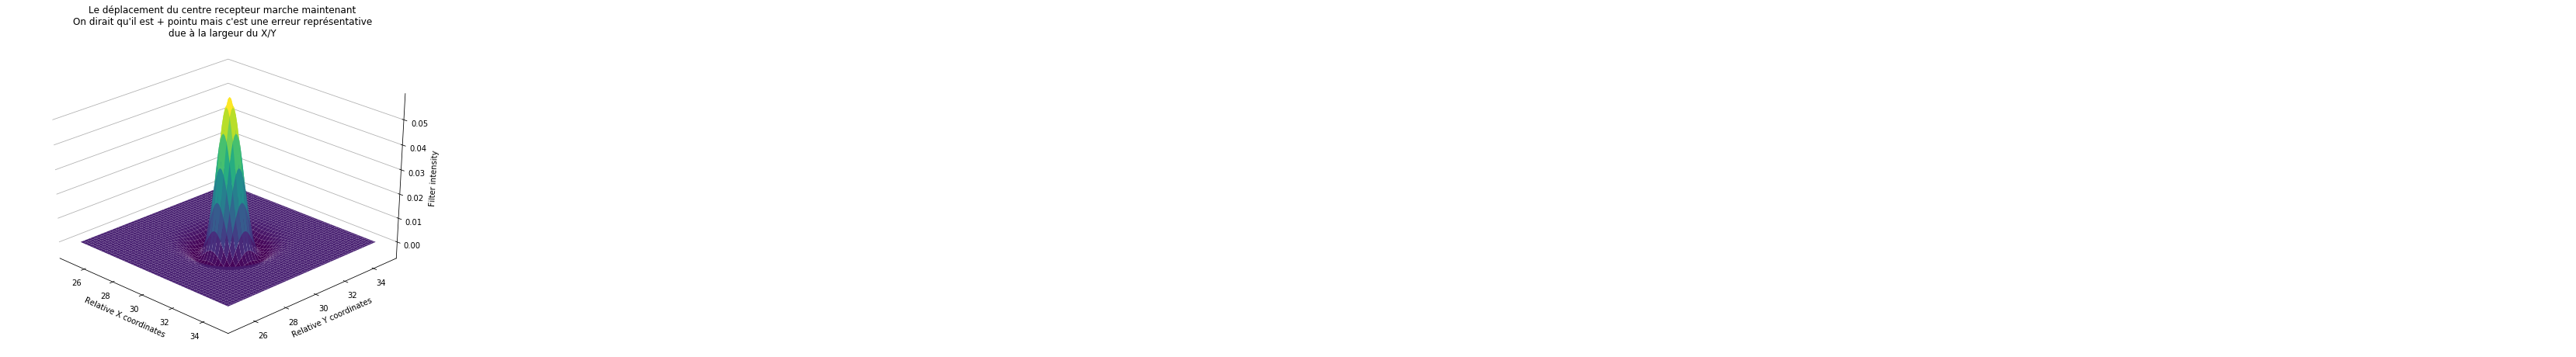

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
X,Y,Z = spatial_filter(x_trans = 30,y_trans = 30)
ax.plot_surface(X,Y,Z, cmap = plt.cm.viridis)

ax.set_zlabel('Filter intensity')
ax.set_xlabel('Relative X coordinates') 
ax.set_ylabel('Relative Y coordinates')

ax.xaxis._axinfo["grid"]["color"] = (1,1,1,0)
ax.yaxis._axinfo["grid"]["color"] = (1,1,1,0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))

ax.set_title('''Le déplacement du centre recepteur marche maintenant\nOn dirait qu'il est + pointu mais c'est une erreur représentative\ndue à la largeur du X/Y''')

ax.view_init(azim = -45, elev=30)

# Filtre temporel continu
Avec les params actuels, qui sont surement les bons, la réponse revient à 0 en 175 ms. J'aimerais éviter que le filtre se désactive de manière permanente, donc après un temps de réfraction je reset le filtre :

In [4]:
# Filtre temporel, c'est le décours de la réponse canonique
# vérifier les params avec Laurent mais ça matche joliment les datas expérimentales
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    k = int(t//(response_time+refrac_time)) #get the signal period we're currently in
    #reset the filter if the refraction is over
    if t > (response_time+refrac_time)*k :
        t = t - (response_time+refrac_time)*k
    
    #t = np.arange(0, total_time*t_res, t_res)
    p1 = K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p2 = K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return (p1-p2)*90 #oups je me suis planté d'un facteur 90, c'est un sacré miss

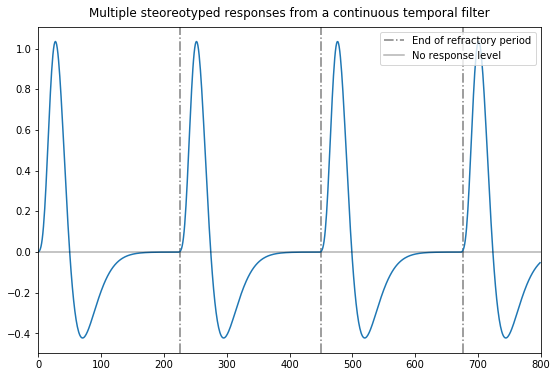

In [5]:
ys = []
plt.figure(figsize = (9,6))
for i in np.linspace(0, 800, 800 ):
    ys.append(temporal_filter(t = i))
    if int(i) == 175+50 or int(i) == 2*(175+50) or int(i) == 3*(175+50) : #oh c'est pas beau
        plt.axvline(i, color = 'k', linestyle = '-.', alpha = .5,
                   label = 'End of refractory period' if int(i) == 175+50 else '')
        
plt.plot(ys)
plt.xlim(0, 800)
plt.axhline(0, color = 'k', alpha = .3, label = 'No response level')
plt.legend(loc = 1)
plt.title('Multiple steoreotyped responses from a continuous temporal filter')
plt.savefig('./figs/2018_10_12_Continuous_temporalfilter.pdf', format = 'pdf', dpi = 200)

# Filtre spatiotemporel
C'est la ou tout se compliquait à cause de la manière dont la résolution était implementée dans le filtre temporel

In [6]:
def spatiotemporal_filter(spatio_X, spatio_Y, spatio_Z, tempo):
    '''
    Returns a 4D spatiotemporal filter, structure as : of tempo length with each element being X/Y/Z,
    each X/Y/Z having the samedimensions as that of the given spatial filter. 
    Temporal resolution is the same as the temporal filter
    --> spatio_X, Y, Z : spatial filter
    --> tempo = temporal filter
    '''
    st_filter = [] #bizarrement c'est plus rapide qu'une array
    for i, temporal_function in enumerate(tempo):
        st_filter.append(Z*temporal_function)
    
    return st_filter

In [7]:
total_time = 800 #total time during which we'll simulate the temporal filter
resolution_time = total_time #we'll use a 1 sampling per ms resolution

X,Y,Z = spatial_filter()
t = [temporal_filter(i) for i in np.linspace(0,total_time, resolution_time)]
st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z, tempo = t)

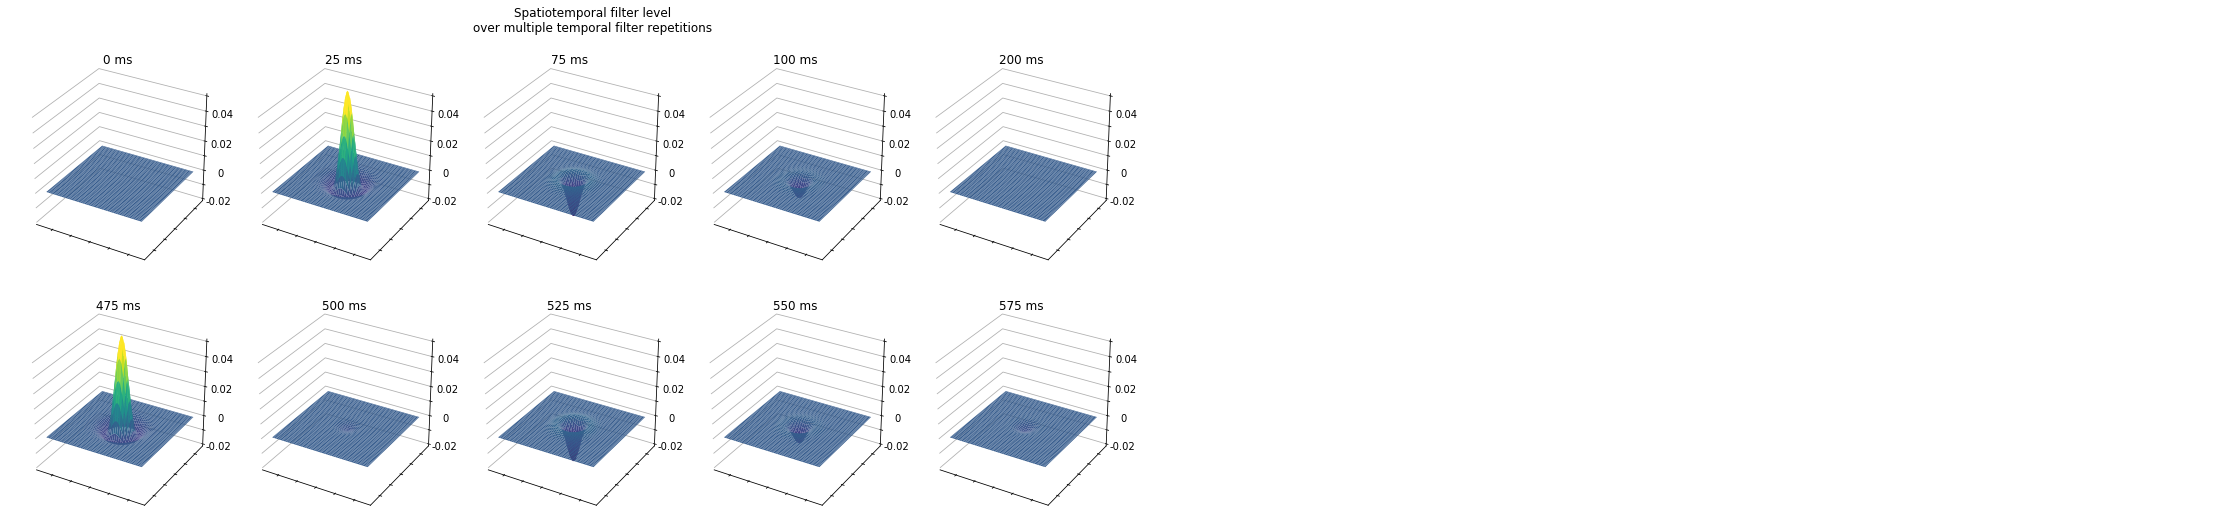

In [8]:
#c'est pas propre mais j'ai eu des tas de pb avec matplotlib alors on va la jouer comme ça
#pas besoin de s'embêter avec les colormaps vu que c'est la meme que celle de la 3D, qui va surement
#finir a coté sur le rapport
plt.figure(figsize = (25,25))
plt.subplots_adjust(bottom = .7, top = .97, wspace = .02,hspace = .02, right = .75)

interesting_times = [st[0], st[25], st[75], st[100], st[200],
                    st[475], st[500], st[525], st[550], st[575]] #chinese curse ?
indexes = [0,25,75,100,200,475,500,525,550,575]

for i, stfilter in enumerate(interesting_times) :
    ax = plt.subplot(2,5,i+1, aspect = 'equal', projection = '3d')
    ax.plot_surface(X,Y, stfilter, vmin = -.02, vmax = .05,
                   cmap = plt.cm.viridis)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([-.02, '', 0, '', 0.02, '', 0.04, ''])
    
    ax.set_zlim(-.02,.05)
    ax.xaxis._axinfo["grid"]["color"] = (1,1,1,0)
    ax.yaxis._axinfo["grid"]["color"] = (1,1,1,0)
    #ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

    ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.set_title('%s ms' %(indexes[int(i)]) ,color = 'k')
    
plt.suptitle('Spatiotemporal filter level\nover multiple temporal filter repetitions',x = .45,y= .99)
plt.savefig('./figs/2018_10_12_SpatioTemporal_filter3D_800ms.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

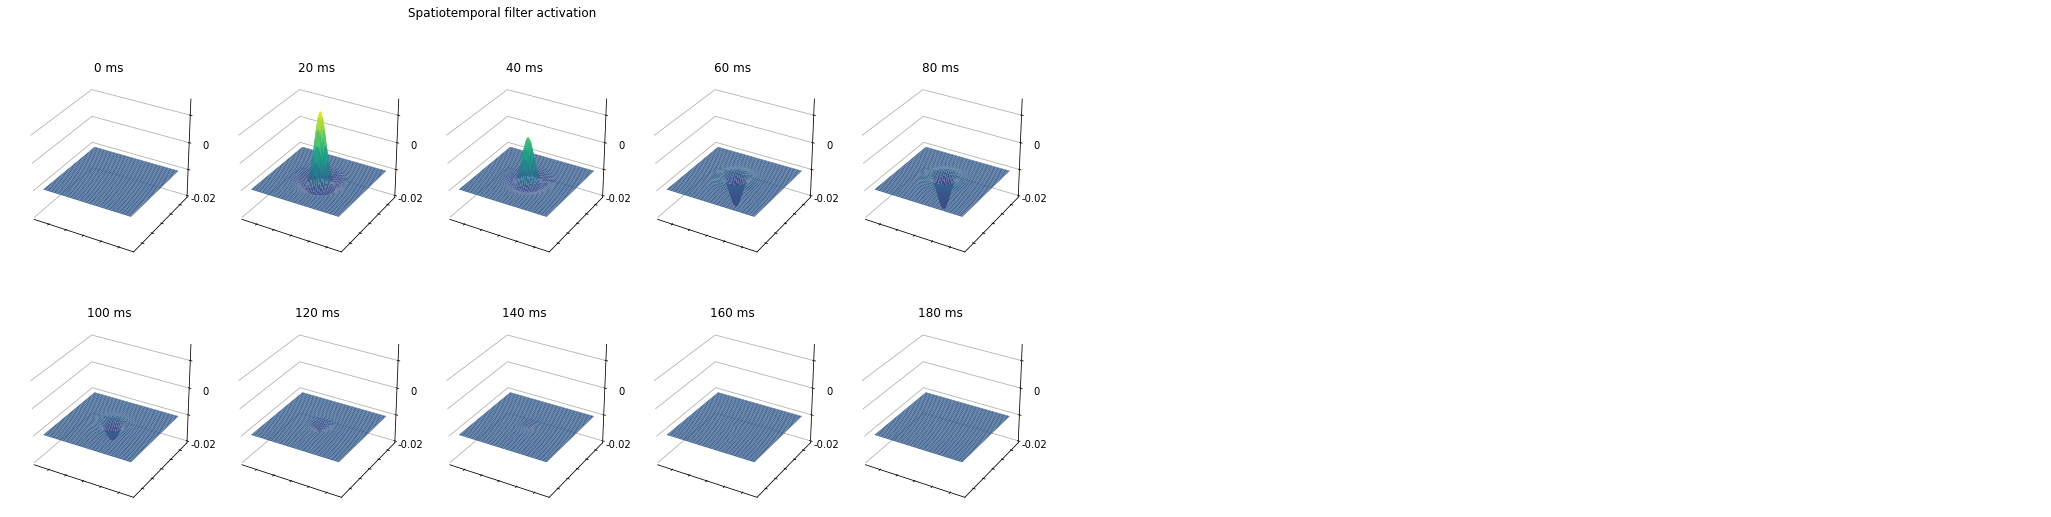

In [9]:
#c'est pas propre mais j'ai eu des tas de pb avec matplotlib alors on va la jouer comme ça
#pas besoin de s'embêter avec les colormaps vu que c'est la meme que celle de la 3D, qui va surement
#finir a coté sur le rapport
import matplotlib.gridspec as gridspec

X,Y,Z = spatial_filter()
ys = [temporal_filter(i) for i in np.linspace(0,200, 200)]

plt.figure(figsize = (25,25))
plt.subplots_adjust(bottom = .7, top = .97, wspace = .02,hspace = .02, right = .7)

for i, t in enumerate(ys[::20]) :
    ax = plt.subplot(2,5,i+1, aspect = 'equal', projection = '3d')
    ax.plot_surface(X,Y, t*Z, vmin = -.02, vmax = .05,
                   cmap = plt.cm.viridis)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([-.02, '', 0, '', 0.02, '', 0.04, ''])
    ax.set_zlim(-.02,.05)
    ax.xaxis._axinfo["grid"]["color"] = (1,1,1,0)
    ax.yaxis._axinfo["grid"]["color"] = (1,1,1,0)
    #ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

    ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
    ax.set_title('%s ms' % (int(i)*20),color = 'k')
    
plt.suptitle('Spatiotemporal filter activation',x = .4,y= .99)
plt.savefig('./figs/2018_10_12_SpatioTemporal_filter3D_200ms.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Stimulation time !
Donc au final on a un filtre avec une résolution temporel res_filter et une stim avec une résolution temporelle res_stim. Donc :

In [10]:
total_time = 800 #total time during which we'll simulate the temporal filter
resolution_time = total_time #we'll use a 1 sampling per ms resolution
wx, wy = 5., 5.
xres, yres = .1, .1


X,Y,Z = spatial_filter(wx = wx, wy = wy, xres = xres, yres = yres)
t = [temporal_filter(i) for i in np.linspace(0,total_time, resolution_time)]
st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z, tempo = t)

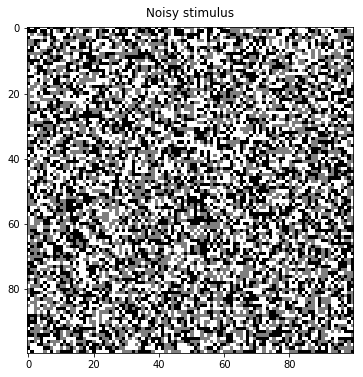

In [11]:
stim_time = 200

#basic 4 level pattern, the same size as the filter
np.random.seed(42)
stimuli = np.random.randint(-1,2, size = (stim_time, int(wx/(xres/2)), int(wy/(yres/2))))
plt.figure(figsize = (8,6))
plt.imshow(stimuli[0], cmap = plt.cm.binary)
plt.title('Noisy stimulus')
plt.show()

In [12]:
filter_over_stim = total_time/stim_time #convertion rate from filter to stim

total_resp = []
for i, st_response in enumerate(st):
    total_resp.append(np.sum(st_response * stimuli[int(i/filter_over_stim)]))

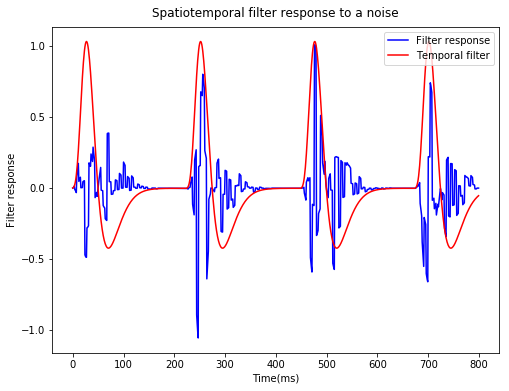

In [13]:
%matplotlib inline
plt.figure(figsize = (8,6))
plt.plot(total_resp, color = 'b', label = 'Filter response')
plt.plot(t, color = 'r', label = 'Temporal filter')
plt.legend(loc = 1) #autobest
plt.title('Spatiotemporal filter response to a noise')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')
plt.savefig('./figs/2018_10_12_STFilter_Reponse_NOISE.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# If the spatiotemporal filter works right, it should produce a response akin to the temporal filter, multiplied by a constant, when shown a constant pattern centered on its center

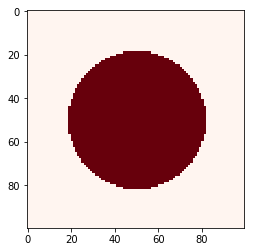

In [14]:
#Et maintenant avec un vrai stim
xx, yy = np.mgrid[:100, :100]
circle = (xx - 50) ** 2 + (yy - 50) ** 2

japanese_flag = (circle < (1000))
plt.imshow(japanese_flag, cmap = plt.cm.Reds)

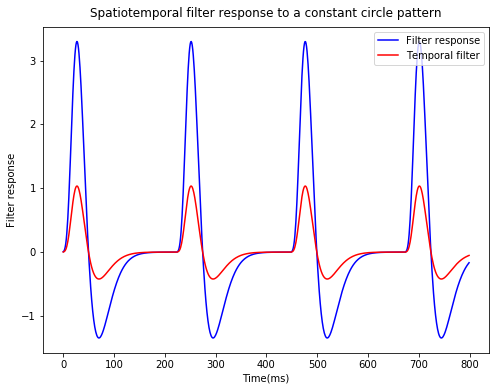

In [15]:
total_resp = []
for i, st_response in enumerate(st):
    total_resp.append(np.sum(st_response * japanese_flag))

plt.figure(figsize = (8,6))
plt.plot(total_resp, color = 'b', label = 'Filter response')
plt.plot(t, color = 'r', label = 'Temporal filter')
plt.legend(loc = 0) #autobest
plt.title('Spatiotemporal filter response to a constant circle pattern')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')
plt.savefig('./figs/2018_10_12_STFilter_Reponse_CONSTANT.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Moving japanese flag, from top left to bottom right
Un élément qui choque c'est que le décours temporel est intrinsèquement oscillatoire et pas déclenché suite à une stimulation comme je voudrais.. Ca risque de synchroniser des régions pour rien autour d'un facteur qui n'existe pas.

Un moyen d'arranger ça serait de passer un argument au filtre temporel, qui serait stimuli * filtre_spatial. Si c'est supérieur à un seuil, c'est que le filtre spatial allait répondre et donc on peut activer la courbe. Sinon on répond pas du tout et on renvoi 0 ?


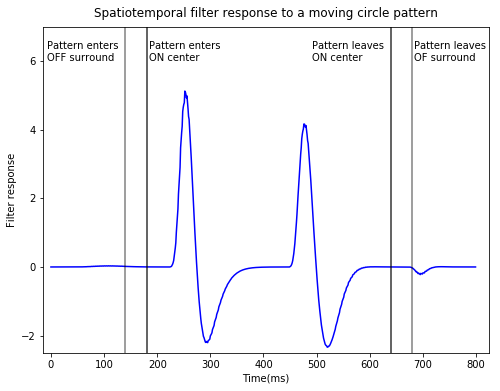

In [16]:
jap_flags = []
stim_time = 200

for i in range(stim_time):
    #Et maintenant avec un vrai stim
    xx, yy = np.mgrid[:100, :100]
    circle = (xx -  (i/2)) ** 2 + (yy - (i/2)) ** 2

    japanese_flag = (circle < (1000))
    jap_flags.append(japanese_flag)

filter_over_stim = total_time/stim_time #convertion rate from filter to stim

jap_resp = []
for i, st_response in enumerate(st):
    jap_resp.append(np.sum(st_response * jap_flags[int(i/filter_over_stim)]))
    

plt.figure(figsize = (8,6))

plt.plot(jap_resp, color = 'b', label = 'Filter response')

plt.axvline(35*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern enters OFF surround',
           alpha = .5)
plt.text(-8, 6, 'Pattern enters\nOFF surround')

plt.axvline(45*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern enters ON center',
           alpha = .8)
plt.text(46*filter_over_stim, 6, 'Pattern enters\nON center')

'''plt.axvline(100*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern centered ON center',
           alpha = 1)
plt.text(101*filter_over_stim, 6, 'Pattern centered on\nON center')'''

plt.axvline(160*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern leaves OFF surround',
           alpha = .8)
plt.text(123*filter_over_stim, 6, 'Pattern leaves\nON center')
plt.axvline(170*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern leaves ON center',
           alpha = .5)
plt.text(171*filter_over_stim, 6, 'Pattern leaves\nOF surround')


plt.ylim(-2.5, 7)
plt.xlim(-15,825)
#plt.legend(loc = (1.01, .72)) 
plt.title('Spatiotemporal filter response to a moving circle pattern')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')
plt.savefig('./figs/2018_10_12_STFilter_Reponse_MOVING.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Trying a modified temporal filter that activates only when spatial activates
Ca marche dans le mauvais sens du terme :

Quand le spatial est activé au dela d'un certain seuil, ça donne la réponse qu'aurait normalement la courbe, sinon ca donne 0. Donc ca oscille de la meme manière sauf que ça oscille en 0 et sa vraie valeur, ça n'a rien a voir avec lancer le décours une fois la réponse passée un certain seuil.

### Update de 18h ça marche :
On itère dans une dimension égale à celle du filtre temporel. L'itération commence avec le filtre en état 'Ouvert'. Si jamais la convolution du stimulus par le filtre spatial (Z * stim) est supérieure à un threshold, le réseau passe en état fermé et commence un décompte temporel, égal à celui du temps de réponse canonique + période réfractaire. Le réseau repasse ensuite en ouvert quand il a fini sa réponse.

I detected something at 92.11514392991239 ms
I detected something at 604.755944931164 ms


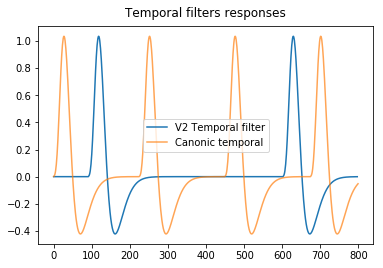

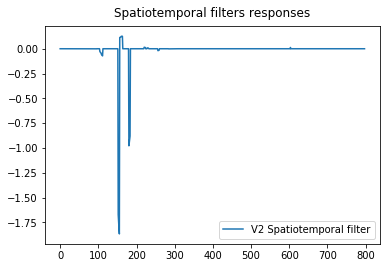

In [17]:
X,Y,Z = spatial_filter(wx = wx, wy = wy, xres = xres, yres = yres)   
default_temporal_filter = [temporal_filter(i) for i in np.linspace(0,total_time, resolution_time)]

np.random.seed(42)

#des stims de déplacements aléatoire et une stim fixée
jap_flags = []
for i in range(200):
    if i != 150 :
        xx, yy = np.mgrid[:100, :100]
        circle = (xx -  (i*np.random.randint(-2,2))) ** 2 + (yy - (i*np.random.randint(-2,2))) ** 2

        japanese_flag = (circle < (1000))
        jap_flags.append(japanese_flag)
    else :
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - 50) ** 2
        
        japanese_flag = (circle < (1000))
        jap_flags.append(japanese_flag)
     
activation_threshold = .001
v2_filter = []
deactivation_delay = 0 #c'est la période de réfraction

#huuuuuge mindfuck, see the algorithm in plain english above
for i in np.linspace(0,800, 800) :
    activation = np.max(Z*jap_flags[int(i/4)-1])
    
    if deactivation_delay == 0 :
        if activation < activation_threshold : #nothing happens
            v2_filter.append(0)
        else : #we start a new countdown
            deactivation_delay = 225
            print('I detected something at %s ms' % i)
            
    else : #we're doing a reponse
        deactivation_delay -=1
        v2_filter.append(temporal_filter(225-deactivation_delay))
        
plt.pause(.1)
             
ys = []
for i in range(800):
    ys.append(np.sum(st[i] * jap_flags[int(i/4)]))
plt.plot(v2_filter, label = 'V2 Temporal filter')
plt.plot(default_temporal_filter, label = 'Canonic temporal', alpha = .7)
plt.legend()
plt.title('Temporal filters responses')
plt.show()

plt.pause(.1)

vanilla_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = default_temporal_filter)
jap_resp_def= []
for i, st_response in enumerate(vanilla_st):
    jap_resp_def.append(np.sum(st_response * jap_flags[int(i/4)]))
    
new_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = v2_filter)
jap_resp= []
for i, st_response in enumerate(new_st):
    jap_resp.append(np.sum(st_response * jap_flags[int(i/4)]))
    
plt.plot(jap_resp, label = 'V2 Spatiotemporal filter')
#plt.plot(jap_resp_def, label = 'Canonic Spatiotemporal filter', alpha = .7)
plt.legend()
plt.title('Spatiotemporal filters responses')
plt.show()

In [18]:
v2_filter[604]

0.008324999184417826

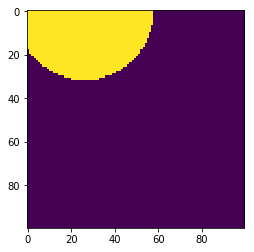

In [19]:
plt.imshow(jap_flags[26])

# A cool animation made during lunchbreak

<IPython.core.display.Javascript object>


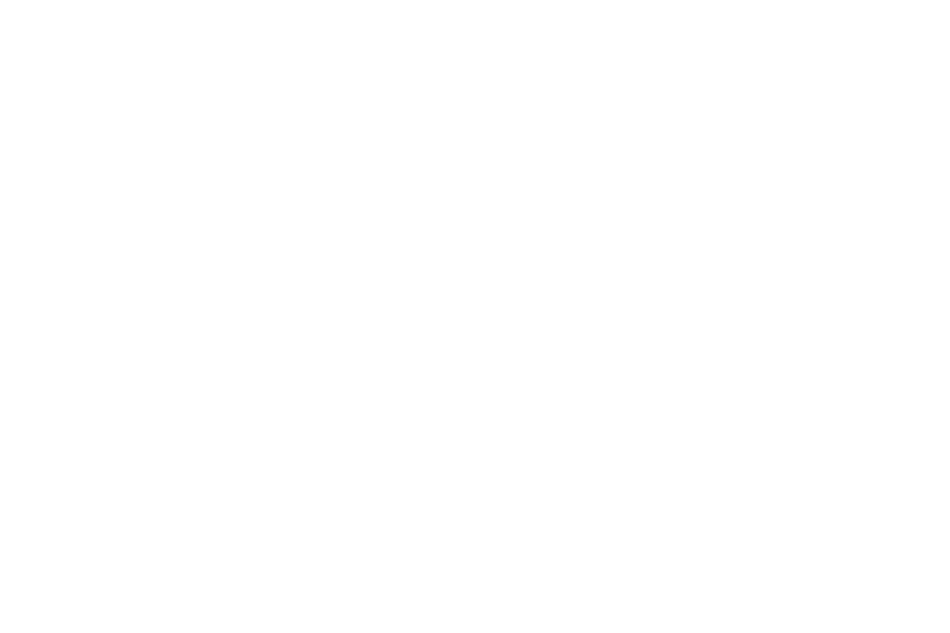

<IPython.core.display.Javascript object>


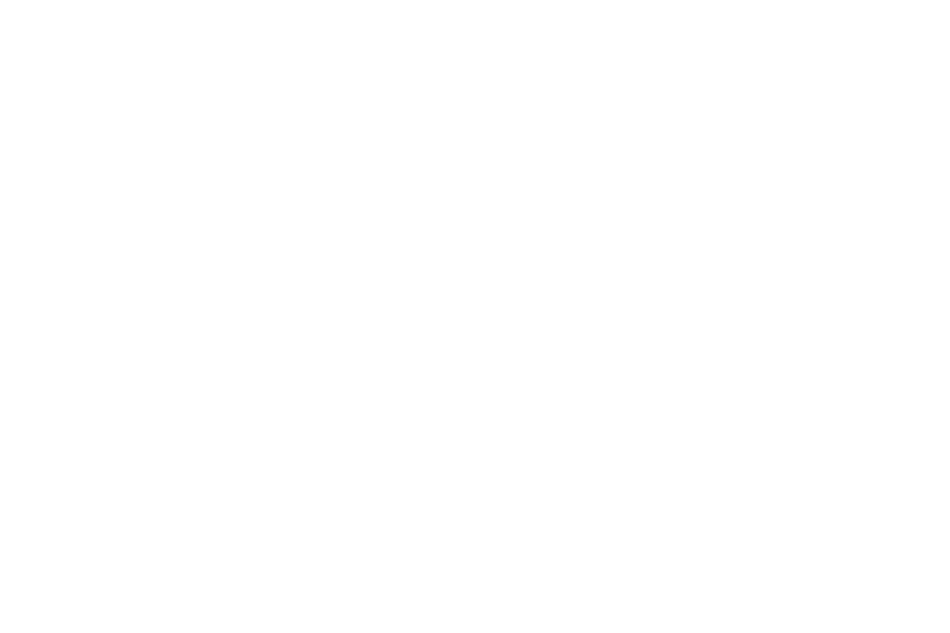

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 213, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/animation.py", line 1446, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(200):
    im = plt.imshow(st[i] * stimuli[int(i/4)], animated=True, cmap = plt.cm.binary)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 10,
                                 repeat = True)
plt.show()